# Banana Lakatan Regression Model with SARIMA
By Menard Gymer V. Rivera 

## Load the Dataset

In [1]:
import pandas as pd

In [2]:
Tilapia_UN = pd.read_excel('./data/banana_lakatan_UN.xlsx')

In [3]:
Tilapia_DA = pd.read_excel('./data/banana_lakatan_DA.xlsx')

In [4]:
Tilapia_UN

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,845,Bananas (lakatan) - Retail,5,KG,5,2020,104.31
1,845,Bananas (lakatan) - Retail,5,KG,5,2020,45.26
2,845,Bananas (lakatan) - Retail,5,KG,5,2020,80.00
3,845,Bananas (lakatan) - Retail,5,KG,5,2020,87.36
4,845,Bananas (lakatan) - Retail,5,KG,5,2020,79.41
...,...,...,...,...,...,...,...
1028,845,Bananas (lakatan) - Retail,5,KG,6,2021,71.88
1029,845,Bananas (lakatan) - Retail,5,KG,6,2021,80.63
1030,845,Bananas (lakatan) - Retail,5,KG,6,2021,87.50
1031,845,Bananas (lakatan) - Retail,5,KG,6,2021,106.25


In [5]:
Tilapia_DA.head()

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,845.0,Bananas (lakatan) - Retail,5.0,KG,5,2020,104.31
1,845.0,Bananas (lakatan) - Retail,5.0,KG,5,2020,45.26
2,845.0,Bananas (lakatan) - Retail,5.0,KG,5,2020,80.00
3,845.0,Bananas (lakatan) - Retail,5.0,KG,5,2020,87.36
4,845.0,Bananas (lakatan) - Retail,5.0,KG,5,2020,79.41


## Extract Necessary Columns (Date and Price)

### UN World Food Programme

In [6]:
Tilapia_UN['date'] = pd.to_datetime(
    Tilapia_UN.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [7]:
Tilapia_UN = Tilapia_UN.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [8]:
Tilapia_UN.head()

,mp_price,date
0,104.31,2020-05-15
1,45.26,2020-05-15
2,80.00,2020-05-15
3,87.36,2020-05-15
4,79.41,2020-05-15


### DA Bantay Presyo

In [9]:
Tilapia_DA['date'] = pd.to_datetime(
    Tilapia_DA.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [10]:
Tilapia_DA = Tilapia_DA.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [11]:
Tilapia_DA.head()

,mp_price,date
0,104.31,2020-05-15
1,45.26,2020-05-15
2,80.00,2020-05-15
3,87.36,2020-05-15
4,79.41,2020-05-15


In [12]:
import matplotlib.pyplot as plt

In [13]:
Tilapia = pd.concat([Tilapia_DA, Tilapia_UN])

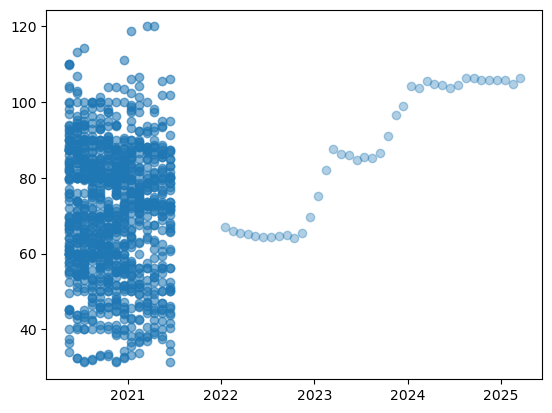

<Figure size 5000x600 with 0 Axes>

In [14]:
plt.scatter(Tilapia['date'], Tilapia['mp_price'], alpha=0.35)
plt.figure(figsize=(50, 6))
plt.show()

In [15]:
from datetime import datetime

In [16]:
# Set Date as the Inex
Tilapia = Tilapia.set_index('date')

In [17]:
# Aggregate samples to mean
Tilapia = Tilapia.resample('MS').mean()

In [18]:
Tilapia['mp_price'] = Tilapia['mp_price'].interpolate(method='linear')

In [19]:
start_date = datetime(2020,1,1)
end_date = datetime(2026,1,1)
lim_tilapia = Tilapia[start_date:end_date]

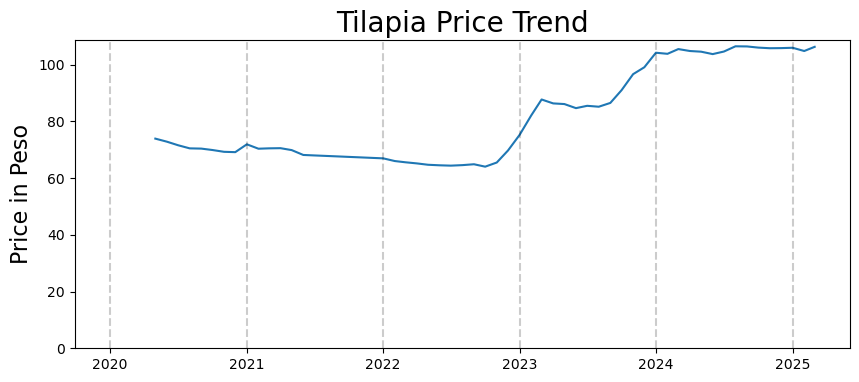

In [20]:
plt.figure(figsize=(10,4))
plt.plot(lim_tilapia)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
plt.ylim(bottom=0)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [21]:
first_diff = lim_tilapia.diff()[1:]

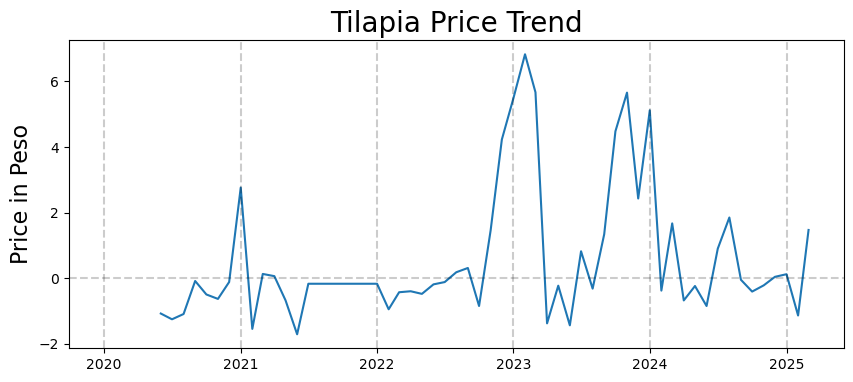

In [22]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

## ACF

In [23]:
from statsmodels.tsa.stattools import acf, pacf

<BarContainer object of 18 artists>

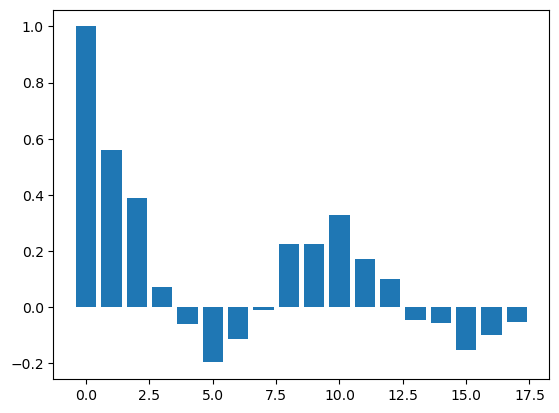

In [24]:
acf_vals = acf(first_diff)
num_lags = 18
plt.bar(range(num_lags), acf_vals[:num_lags])

### Based on ACF, we should start with a seasonal MA process

## PACF

<BarContainer object of 18 artists>

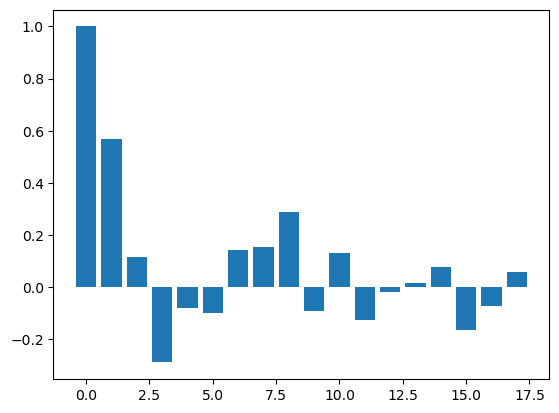

In [25]:
pacf_vals = pacf(first_diff)
num_lags = 18
plt.bar(range(num_lags), pacf_vals[:num_lags])

### Based on PACF, we should start with a seasonal AR process

## Get training and testing sets

In [26]:
from datetime import timedelta

In [27]:
train_end = datetime(2024,9,1)
test_end = datetime(2025,3,1)

train_data = lim_tilapia[:train_end]
test_data = lim_tilapia[train_end + timedelta(days=1):test_end]

In [28]:
Tilapia.describe()

,mp_price
count,59.000000
mean,81.426054
std,16.204994
min,64.020000
25%,67.719574
50%,71.897265
75%,101.380000
max,106.450000


## Fit the SARIMA Model

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [30]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [31]:
from time import time

In [32]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21297D+00    |proj g|=  3.02541D-01

At iterate    5    f=  2.13867D+00    |proj g|=  2.65554D-03

At iterate   10    f=  2.13803D+00    |proj g|=  1.41756D-02

At iterate   15    f=  2.13771D+00    |proj g|=  8.03224D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     17      1     0     0   8.032D-07   2.138D+00
  F =   2.1377139223917676     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model Fi

 This problem is unconstrained.


In [33]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             mp_price   No. Observations:                   53
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -113.299
Date:                              Thu, 22 May 2025   AIC                            232.598
Time:                                      09:35:24   BIC                            238.451
Sample:                                  05-01-2020   HQIC                           234.842
                                       - 09-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.4220      0.925      0.456      0.648      -1.391       2.235
ma.S.L12      -0.19

In [34]:
print(type(test_data))
print(test_data.columns)
print(test_data.head())

<class 'pandas.core.frame.DataFrame'>
Index(['mp_price'], dtype='object')
            mp_price
date                
2024-10-01    105.99
2024-11-01    105.77
2024-12-01    105.81
2025-01-01    105.93
2025-02-01    104.79


In [35]:
# Assuming test_data is a DataFrame with a single column named "mp_price"
test_series = test_data['mp_price']

In [36]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [37]:
predictions

date
2024-10-01    107.381675
2024-11-01    108.734372
2024-12-01    109.473927
2025-01-01    110.887657
2025-02-01    111.092240
2025-03-01    111.720383
Freq: MS, Name: predicted_mean, dtype: float64

In [38]:
residuals

date
2024-10-01   -1.391675
2024-11-01   -2.964372
2024-12-01   -3.663927
2025-01-01   -4.957657
2025-02-01   -6.302240
2025-03-01   -5.460383
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

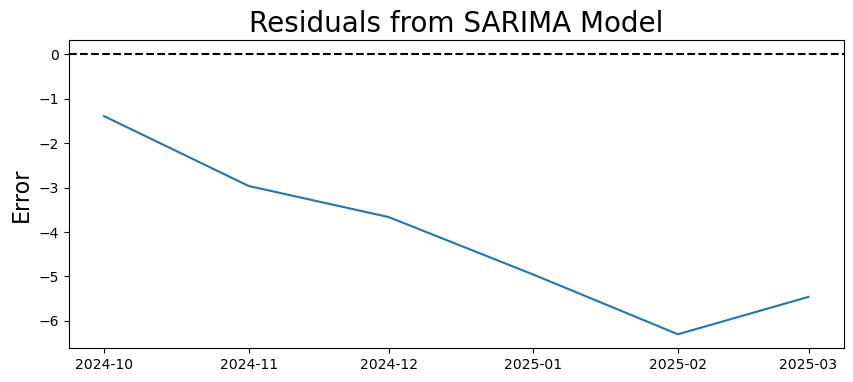

In [39]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

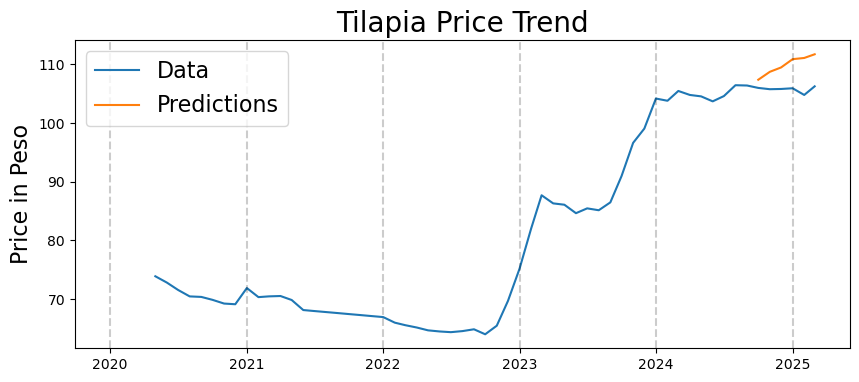

In [40]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Using the Rolling Forecast Origin

In [41]:
rolling_predictions = test_series.copy()
for train_end in test_series.index:
    train_data = lim_tilapia[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21297D+00    |proj g|=  3.02541D-01

At iterate    5    f=  2.13867D+00    |proj g|=  2.65554D-03

At iterate   10    f=  2.13803D+00    |proj g|=  1.41756D-02

At iterate   15    f=  2.13771D+00    |proj g|=  8.03224D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     17      1     0     0   8.032D-07   2.138D+00
  F =   2.1377139223917676     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
/tmp/ipykernel_86333/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.
/tmp/ipykernel_86333/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate    5    f=  2.12884D+00    |proj g|=  9.70722D-04

At iterate   10    f=  2.12875D+00    |proj g|=  1.54204D-02

At iterate   15    f=  2.12771D+00    |proj g|=  4.91659D-03

At iterate   20    f=  2.12766D+00    |proj g|=  3.27223D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     24      1     0     0   4.753D-07   2.128D+00
  F =   2.1276619075809804     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

/tmp/ipykernel_86333/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.
/tmp/ipykernel_86333/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate    5    f=  2.11274D+00    |proj g|=  9.57158D-04

At iterate   10    f=  2.11263D+00    |proj g|=  9.29503D-03

At iterate   15    f=  2.11211D+00    |proj g|=  8.48245D-03

At iterate   20    f=  2.11182D+00    |proj g|=  1.02258D-03

At iterate   25    f=  2.11172D+00    |proj g|=  4.88359D-04

At iterate   30    f=  2.11168D+00    |proj g|=  1.79811D-04

At iterate   35    f=  2.11168D+00    |proj g|=  1.64298D-04

At iterate   40    f=  2.11167D+00    |proj g|=  1.22257D-04

At iterate   45    f=  2.11167D+00    |proj g|=  1.81759D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     49     55   

/tmp/ipykernel_86333/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.18146D+00    |proj g|=  4.01881D-01

At iterate    5    f=  2.10553D+00    |proj g|=  2.23649D-03

At iterate   10    f=  2.10406D+00    |proj g|=  3.72042D-03

At iterate   15    f=  2.10371D+00    |proj g|=  3.59796D-03

At iterate   20    f=  2.10350D+00    |proj g|=  5.32408D-04

At iterate   25    f=  2.10344D+00    |proj g|=  4.03008D-04

At iterate   30    f=  2.10343D+00    |proj g|=  5.59346D-04

At iterate   35    f=  2.10343D+00    |proj g|=  2.02928D-04

At iterate   40    f=  2.10342D+00    |proj g|=  1.23759D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/tmp/ipykernel_86333/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred


In [42]:
rolling_residuals = test_series - rolling_predictions

Text(0, 0.5, 'Error')

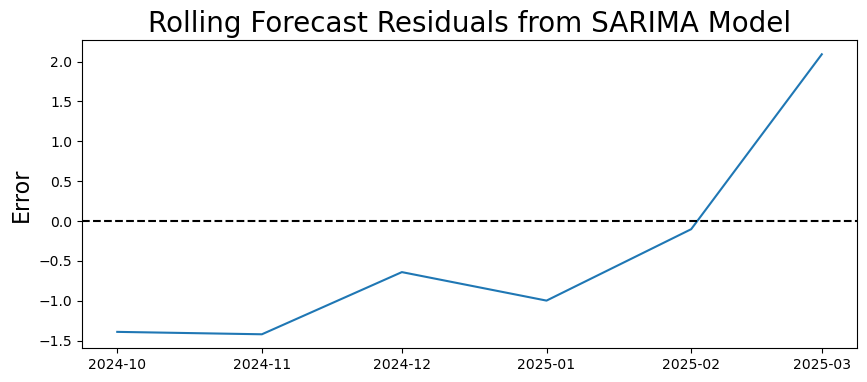

In [43]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

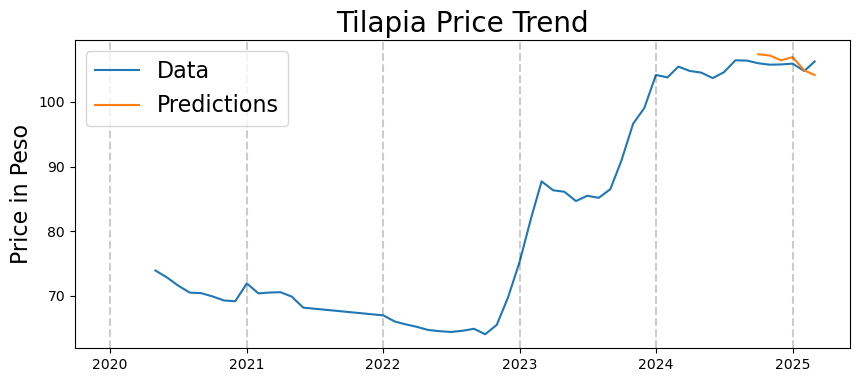

In [44]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [45]:
import numpy as np

In [46]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_series)),4))

Mean Absolute Percent Error: 0.0105


In [47]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 1.2750235372309011


## Future Predictions (2025)

In [48]:
#get the predictions and residuals
predictions = model_fit.forecast(12)
# predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [49]:
predictions

2025-03-01    104.168491
2025-04-01    104.200151
2025-05-01    104.198854
2025-06-01    104.344702
2025-07-01    104.271163
2025-08-01    104.612398
2025-09-01    104.441402
2025-10-01    103.503149
2025-11-01    102.714119
2025-12-01    102.917817
2026-01-01    103.130179
2026-02-01    103.884751
Freq: MS, Name: predicted_mean, dtype: float64

In [50]:
residuals

2024-10-01         NaN
2024-11-01         NaN
2024-12-01         NaN
2025-01-01         NaN
2025-02-01         NaN
2025-03-01    2.091509
2025-04-01         NaN
2025-05-01         NaN
2025-06-01         NaN
2025-07-01         NaN
2025-08-01         NaN
2025-09-01         NaN
2025-10-01         NaN
2025-11-01         NaN
2025-12-01         NaN
2026-01-01         NaN
2026-02-01         NaN
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

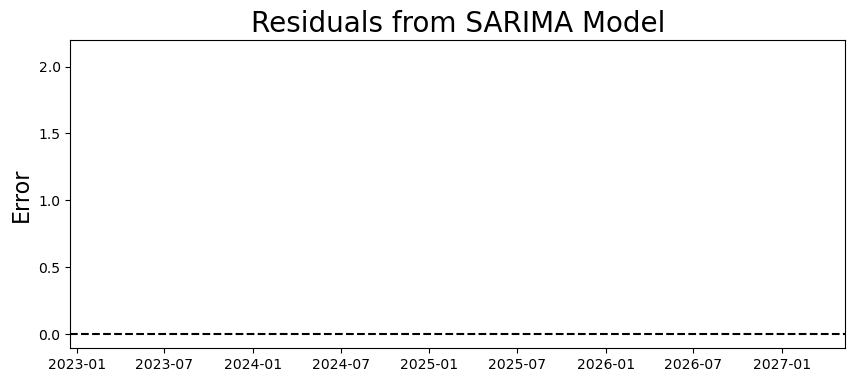

In [51]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

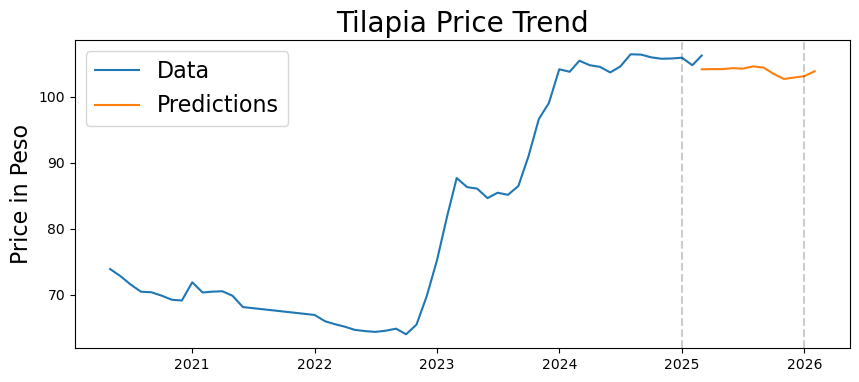

In [52]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(2025,2027):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [53]:
# Tilapia 100g
# Protein = 19g
protein = 1.1*10
# Carbohydrates = 0g
carbs = 27.2*10
# Fats = 2.48 g
fats = 0.3*10
# Fiber 0g
fiber = 2.6*10

In [54]:
protein_projection = protein / predictions

Text(0, 0.5, 'Protein in Grams')

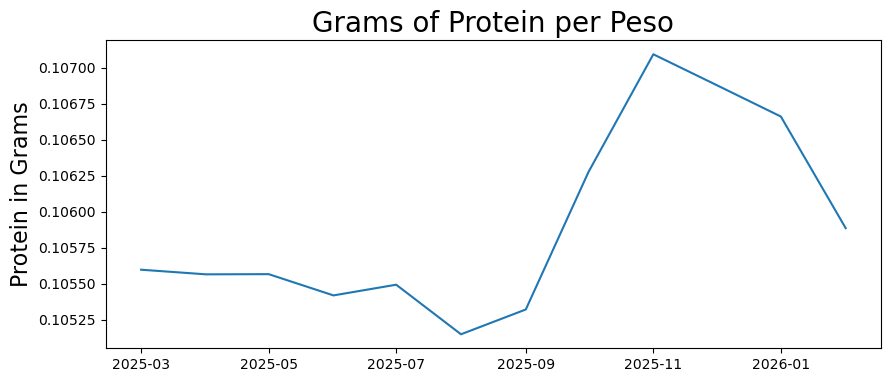

In [62]:
plt.figure(figsize=(10,4))

plt.plot(protein_projection)

plt.title('Grams of Protein per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [55]:
carbs_projection = carbs / predictions

Text(0, 0.5, 'Protein in Grams')

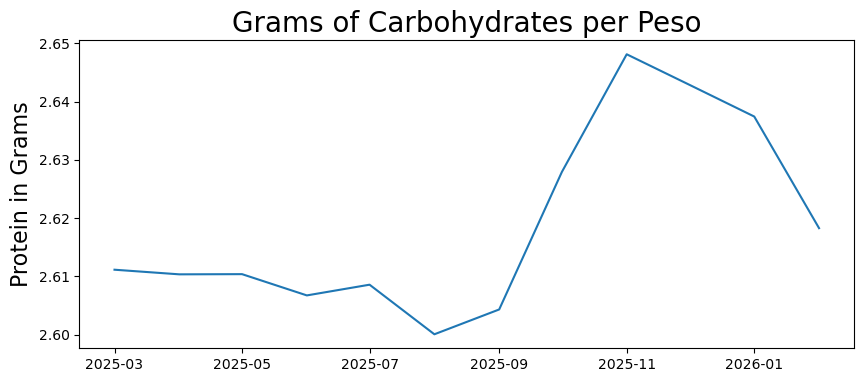

In [56]:
plt.figure(figsize=(10,4))

plt.plot(carbs_projection)

plt.title('Grams of Carbohydrates per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [57]:
fats_projection = fats / predictions

Text(0, 0.5, 'Protein in Grams')

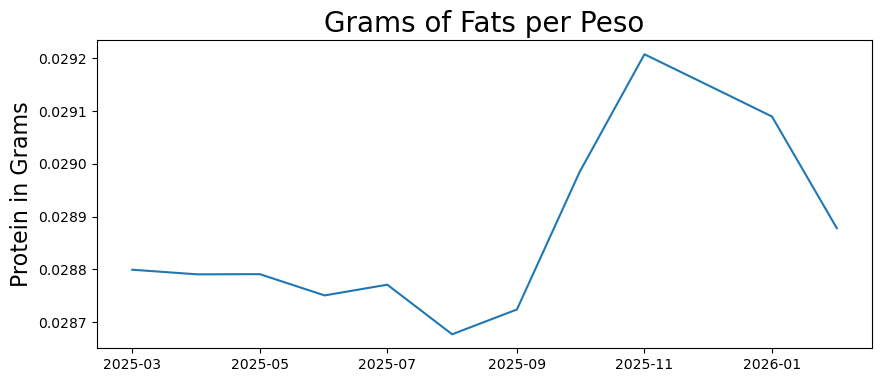

In [58]:
plt.figure(figsize=(10,4))

plt.plot(fats_projection)

plt.title('Grams of Fats per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [59]:
fiber_projection = fiber / predictions

Text(0, 0.5, 'Protein in Grams')

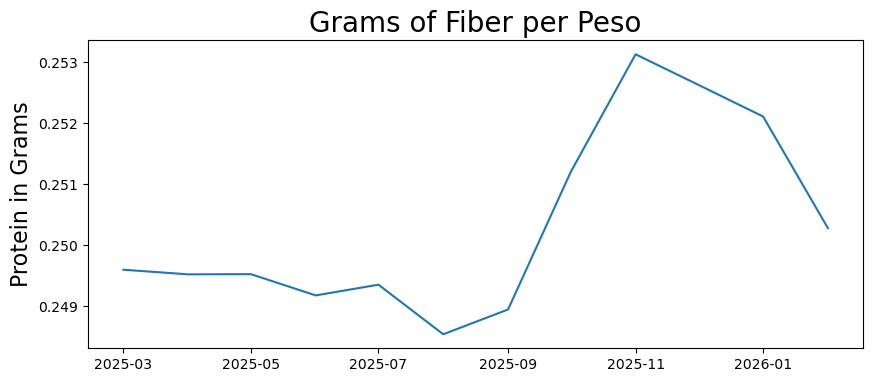

In [60]:
plt.figure(figsize=(10,4))

plt.plot(fiber_projection)

plt.title('Grams of Fiber per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [61]:
protein_projection.to_csv('./protein.csv', index=True)
carbs_projection.to_csv('./carbs.csv', index=True)
fats_projection.to_csv('./fats.csv', index=True)
fiber_projection.to_csv('./fiber.csv', index=True)